# **Exercise 10.3**
# **glass-or-table**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip

Streaming output truncated to the last 5000 lines.
  inflating: table-or-glass/training_set/glass/glass (1329).jpg  
  inflating: table-or-glass/training_set/glass/glass (127).jpg  
  inflating: table-or-glass/training_set/glass/glass (1903).jpg  
  inflating: table-or-glass/training_set/glass/glass (1000).jpg  
  inflating: table-or-glass/training_set/glass/glass (1450).jpg  
  inflating: table-or-glass/training_set/glass/glass (1145).jpg  
  inflating: table-or-glass/training_set/glass/glass (1515).jpg  
  inflating: table-or-glass/training_set/glass/glass (2293).jpg  
  inflating: table-or-glass/training_set/glass/glass (1846).jpg  
  inflating: table-or-glass/training_set/glass/glass (2339).jpg  
  inflating: table-or-glass/training_set/glass/glass (2456).jpg  
  inflating: table-or-glass/training_set/glass/glass (977).jpg  
  inflating: table-or-glass/training_set/glass/glass (2006).jpg  
  inflating: table-or-glass/training_set/glass/glass (1780).jpg  
  inflating: table-or-glass

In [41]:
directory = "/content/gdrive/My Drive/Datasets/pneumonia-or-healthy/"

In [4]:
import numpy as np
import pandas as pd
import pathlib
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

In [42]:
path = pathlib.Path(directory)
train_dir = path / 'training_set'
validation_dir = path / 'test_set'

In [43]:
train_table_dir = train_dir / 'table'
train_glass_dir = train_dir /'glass'
validation_table_dir = validation_dir / 'table'
validation_glass_dir = validation_dir / 'glass'

In [44]:
num_train_table = len([f for f in os.listdir(train_table_dir)if os.path.isfile(os.path.join(train_table_dir, f))])
num_train_glass = len([f for f in os.listdir(train_glass_dir)if os.path.isfile(os.path.join(train_glass_dir, f))])
num_validation_table = len([f for f in os.listdir(validation_table_dir)if os.path.isfile(os.path.join(validation_table_dir, f))])
num_validation_glass = len([f for f in os.listdir(validation_glass_dir)if os.path.isfile(os.path.join(validation_glass_dir, f))])

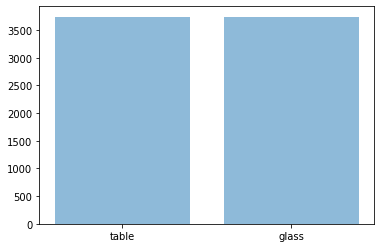

In [45]:
plt.bar(['table', 'glass'], [num_train_table + num_validation_table, num_train_glass + num_validation_glass], align='center', alpha=0.5)
plt.show()

In [46]:
total_train = len(os.listdir(train_table_dir)) + len(os.listdir(validation_table_dir))
total_val = len(os.listdir(train_glass_dir)) + len(os.listdir(validation_glass_dir))

In [47]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [48]:
batch_size = 32
img_height = 100
img_width = 100

In [49]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(img_height, img_width),
                                                           class_mode='binary')

Found 5236 images belonging to 2 classes.


In [50]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(img_height, img_width),
                                                              class_mode='binary')

Found 2247 images belonging to 2 classes.


In [51]:
def relu_batchnorm_layer(input):
    return BatchNormalization()(ReLU()(input))

In [52]:
def custom_loss_function(y_true, y_pred):
   squared_difference = tf.square(float(y_true) - float(y_pred))
   return tf.reduce_mean(squared_difference, axis=-1)

In [53]:
def residual_block(input, downsample: bool, filters: int, kernel_size: int = 3):
    int_output = Conv2D(filters=filters, kernel_size=kernel_size, 
                        strides= (1 if not downsample else 2), 
                        padding="same")(input)
    int_output = relu_batchnorm_layer(int_output)
    int_output = Conv2D(filters=filters, kernel_size=kernel_size, 
                        padding="same")(int_output)

    if downsample:
        int_output2 = Conv2D(filters=filters, kernel_size=1, strides=2,
                             padding="same")(input)
        output = Add()([int_output2, int_output]) 
    else:
        output = Add()([input, int_output])

    output = relu_batchnorm_layer(output)
    return output

In [54]:
inputs = Input(shape=(100, 100, 3))
num_filters = 32
    
t = BatchNormalization()(inputs)
t = Conv2D(kernel_size=3,
           strides=1,
           filters=32,
           padding="same")(t)
t = relu_batchnorm_layer(t)
    
num_blocks_list = [1, 3, 5, 6, 1]
for i in range(len(num_blocks_list)):
    num_blocks = num_blocks_list[i]
    for j in range(num_blocks):
        t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
    num_filters *= 2
    
t = AveragePooling2D(4)(t)
t = Flatten()(t)
outputs = Dense(1, activation='sigmoid')(t)
    
model = Model(inputs, outputs)

In [55]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, 100, 100, 3)  12          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 100, 100, 32) 896         batch_normalization_34[0][0]     
__________________________________________________________________________________________________
re_lu_33 (ReLU)                 (None, 100, 100, 32) 0           conv2d_37[0][0]                  
____________________________________________________________________________________________

In [56]:
model.compile(
        optimizer='adam',
        loss=custom_loss_function,
        metrics=['accuracy']
    )

In [57]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=5,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/5
116/116 [==============================] - 55s 442ms/step - loss: 0.3054 - accuracy: 0.6366 - val_loss: 0.5016 - val_accuracy: 0.4984
Epoch 2/5
116/116 [==============================] - 41s 349ms/step - loss: 0.1567 - accuracy: 0.7780
Epoch 3/5
116/116 [==============================] - 41s 349ms/step - loss: 0.1224 - accuracy: 0.8322
Epoch 4/5
116/116 [==============================] - 41s 349ms/step - loss: 0.0969 - accuracy: 0.8724
Epoch 5/5
116/116 [==============================] - 41s 350ms/step - loss: 0.0859 - accuracy: 0.8847


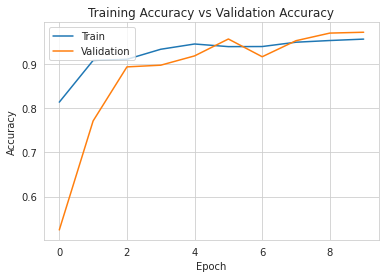

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

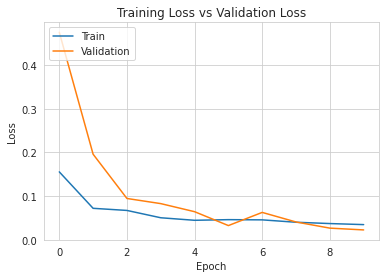

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()